In [1]:
import numpy as np
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import pearsonr

In [2]:
fred = Fred(api_key='321467cef92af0c44aa2aaf01257acc5')
cpi = fred.get_series('CPIAUCSL')
inflation = cpi.pct_change(periods = 12) * 100 
inflation.dropna(inplace = True)
inflation_df = pd.DataFrame(inflation, columns=['inflation'])
inflation_df.index.name = 'date'
inflation_df.head(10)                                                                                                                                                                                                                                                   

C:\Users\nitin\AppData\Local\Temp\ipykernel_18588\3683001085.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inflation = cpi.pct_change(periods = 12) * 100


,inflation
date,
1948-01-01,10.242086
1948-02-01,9.481961
1948-03-01,6.818182
1948-04-01,8.272727
1948-05-01,9.384966
1948-06-01,9.375000
1948-07-01,9.761583
1948-08-01,9.062500
1948-09-01,6.654991


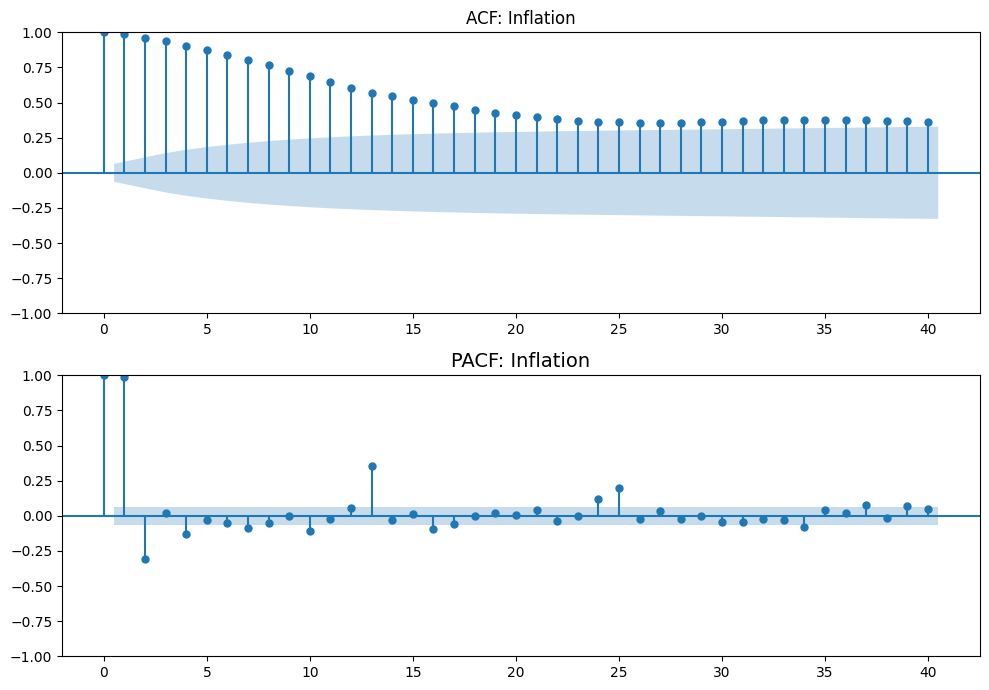

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))

plot_acf(inflation_df['inflation'], lags=40, ax=axes[0])
axes[0].set_title('ACF: Inflation')
plot_pacf(inflation_df['inflation'], lags=40, ax=axes[1])
axes[1].set_title('PACF: Inflation', fontsize=14)
plt.tight_layout()
plt.show()

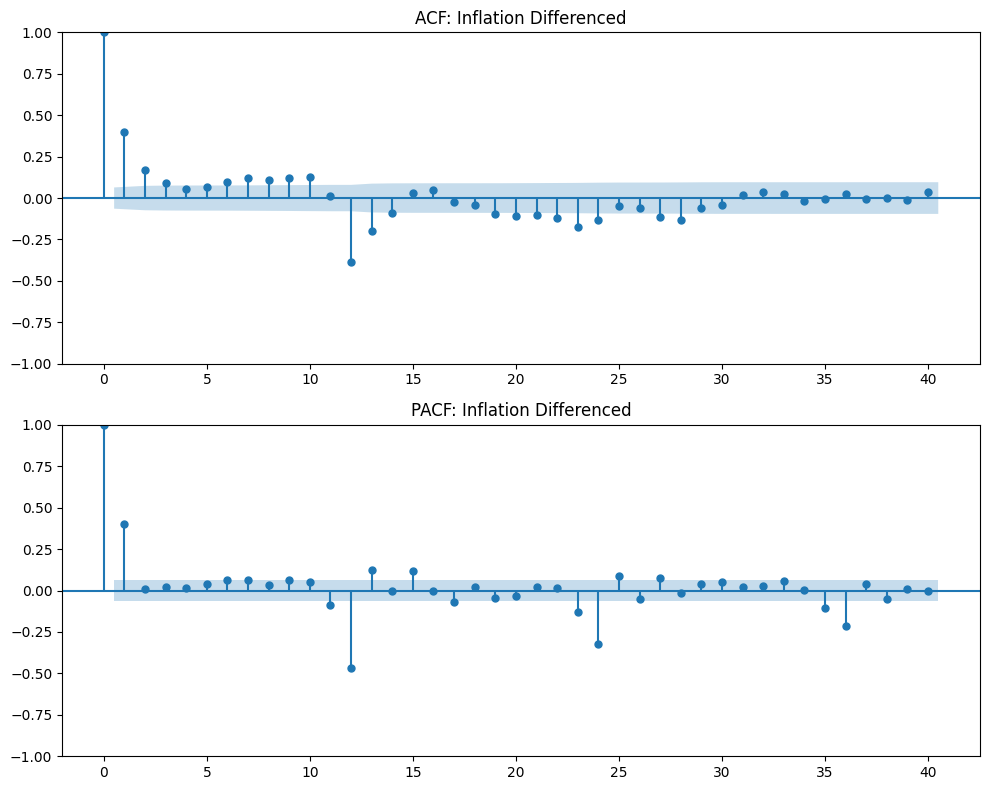

In [4]:
inflation_diff = inflation_df['inflation'].diff().dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(inflation_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF: Inflation Differenced')
plot_pacf(inflation_diff, lags=40, ax=axes[1])
axes[1].set_title('PACF: Inflation Differenced')
plt.tight_layout()
plt.show()

In [5]:
oil = fred.get_series('DCOILWTICO') 
unemployment = fred.get_series('UNRATE')    
m2 = fred.get_series('M2SL')

exo_df = pd.DataFrame({'oil': oil, 'unemployment': unemployment, 'm2': m2})
exo_df = exo_df.resample('ME').last()  
exo_df.index.name = 'date'

inflation_exo = pd.concat([inflation_df, exo_df], axis=1)
inflation_exo.ffill(inplace=True)
inflation_exo.dropna(inplace=True)

inflation_exo.head(10)


,inflation,oil,unemployment,m2
date,,,,
1986-01-31,3.973510,18.95,6.7,2502.1
1986-02-01,3.198495,18.95,6.7,2502.1
1986-02-28,3.198495,13.23,7.2,2512.9
1986-03-01,2.153558,13.23,7.2,2512.9
1986-03-31,2.153558,10.25,7.2,2533.1
1986-04-01,1.588785,10.25,7.2,2533.1
1986-04-30,1.588785,13.38,7.1,2557.8
1986-05-01,1.679104,13.38,7.1,2557.8
1986-05-31,1.679104,14.30,7.2,2584.8


In [6]:
adf_oil = adfuller(inflation_exo['oil'])
print(f'ADF Statistic for oil: {adf_oil[0]}')
print(f'p-value for oil: {adf_oil[1]}\n')

adf_unemployment = adfuller(inflation_exo['unemployment'])
print(f'ADF Statistic for unemployment: {adf_unemployment[0]}')
print(f'p-value for unemployment: {adf_unemployment[1]}\n')

adf_m2 = adfuller(inflation_exo['m2'])
print(f'ADF Statistic for m2: {adf_m2[0]}')
print(f'p-value for m2: {adf_m2[1]}')

ADF Statistic for oil: -2.4804062526865165
p-value for oil: 0.12031476957202086

ADF Statistic for unemployment: -2.90443230242312
p-value for unemployment: 0.044835003413174195

ADF Statistic for m2: 1.0836280611717417
p-value for m2: 0.9950744439833598


In [7]:
inflation_exo['oil_diff'] = inflation_exo['oil'].diff() 
inflation_exo['m2_diff'] = inflation_exo['m2'].diff()
inflation_exo.dropna(inplace=True)  

inflation_exo.head(10)

,inflation,oil,unemployment,m2,oil_diff,m2_diff
date,,,,,,
1986-02-01,3.198495,18.95,6.7,2502.1,0.00,0.0
1986-02-28,3.198495,13.23,7.2,2512.9,-5.72,10.8
1986-03-01,2.153558,13.23,7.2,2512.9,0.00,0.0
1986-03-31,2.153558,10.25,7.2,2533.1,-2.98,20.2
1986-04-01,1.588785,10.25,7.2,2533.1,0.00,0.0
1986-04-30,1.588785,13.38,7.1,2557.8,3.13,24.7
1986-05-01,1.679104,13.38,7.1,2557.8,0.00,0.0
1986-05-31,1.679104,14.30,7.2,2584.8,0.92,27.0
1986-06-01,1.767442,14.30,7.2,2584.8,0.00,0.0


In [8]:
adf_oil_diff = adfuller(inflation_exo['oil_diff'])
print(f'ADF Statistic for oil difference: {adf_oil_diff[0]}')
print(f'p-value for oil difference: {adf_oil_diff[1]}\n')

adf_m2_diff = adfuller(inflation_exo['m2_diff'])
print(f'ADF Statistic for m2 difference: {adf_m2_diff[0]}') 
print(f'p-value for m2 difference: {adf_m2_diff[1]}')   

ADF Statistic for oil difference: -17.98325385964733
p-value for oil difference: 2.770191558887711e-30

ADF Statistic for m2 difference: -3.7045596588102163
p-value for m2 difference: 0.0040494736665284015


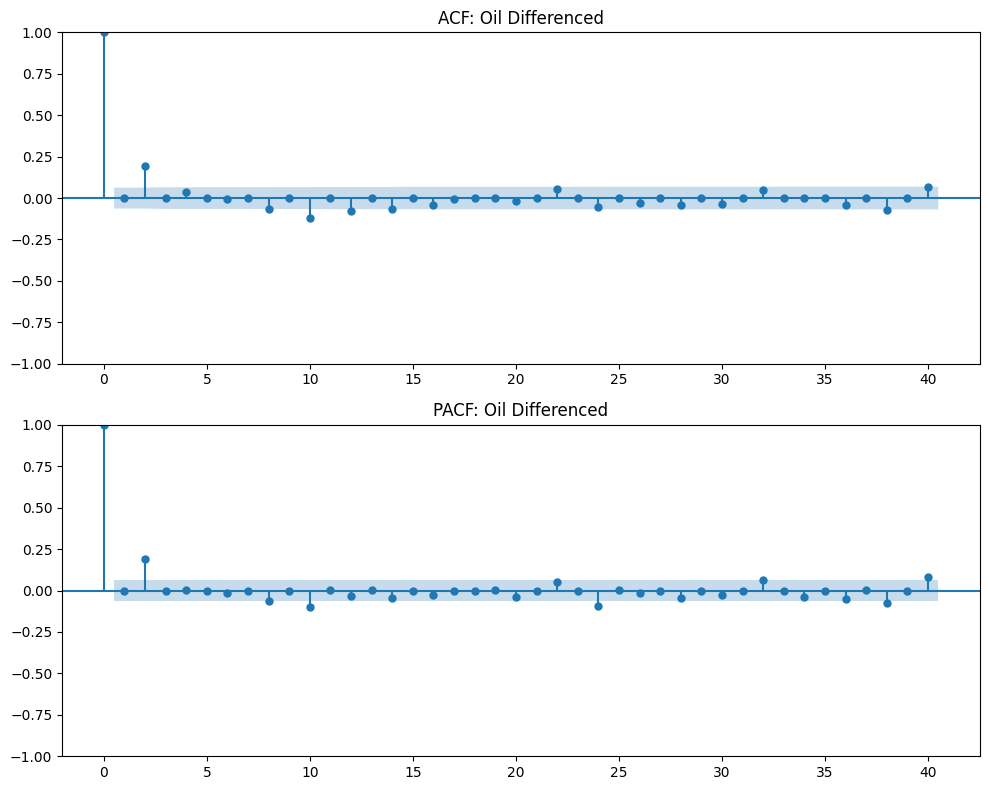

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(inflation_exo['oil_diff'], lags=40, ax=axes[0])
axes[0].set_title('ACF: Oil Differenced')
plot_pacf(inflation_exo['oil_diff'], lags=40, ax=axes[1])
axes[1].set_title('PACF: Oil Differenced')
plt.tight_layout()
plt.show()

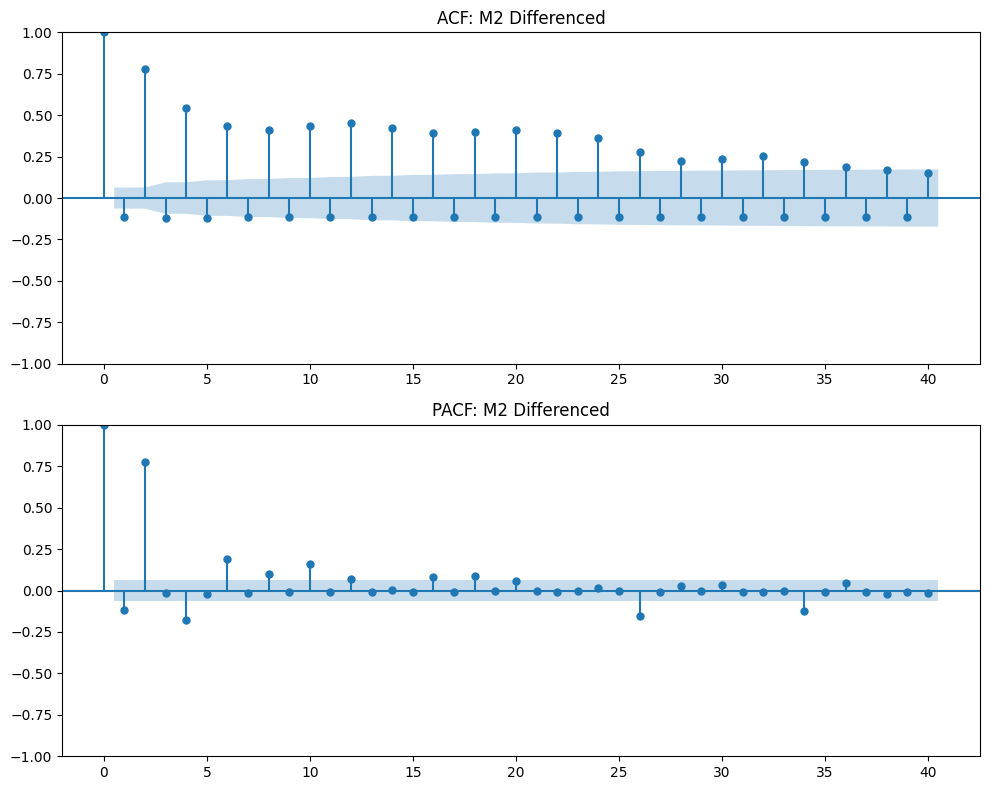

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(inflation_exo['m2_diff'], lags=40, ax=axes[0])
axes[0].set_title('ACF: M2 Differenced')
plot_pacf(inflation_exo['m2_diff'], lags=40, ax=axes[1])
axes[1].set_title('PACF: M2 Differenced')
plt.tight_layout()
plt.show()

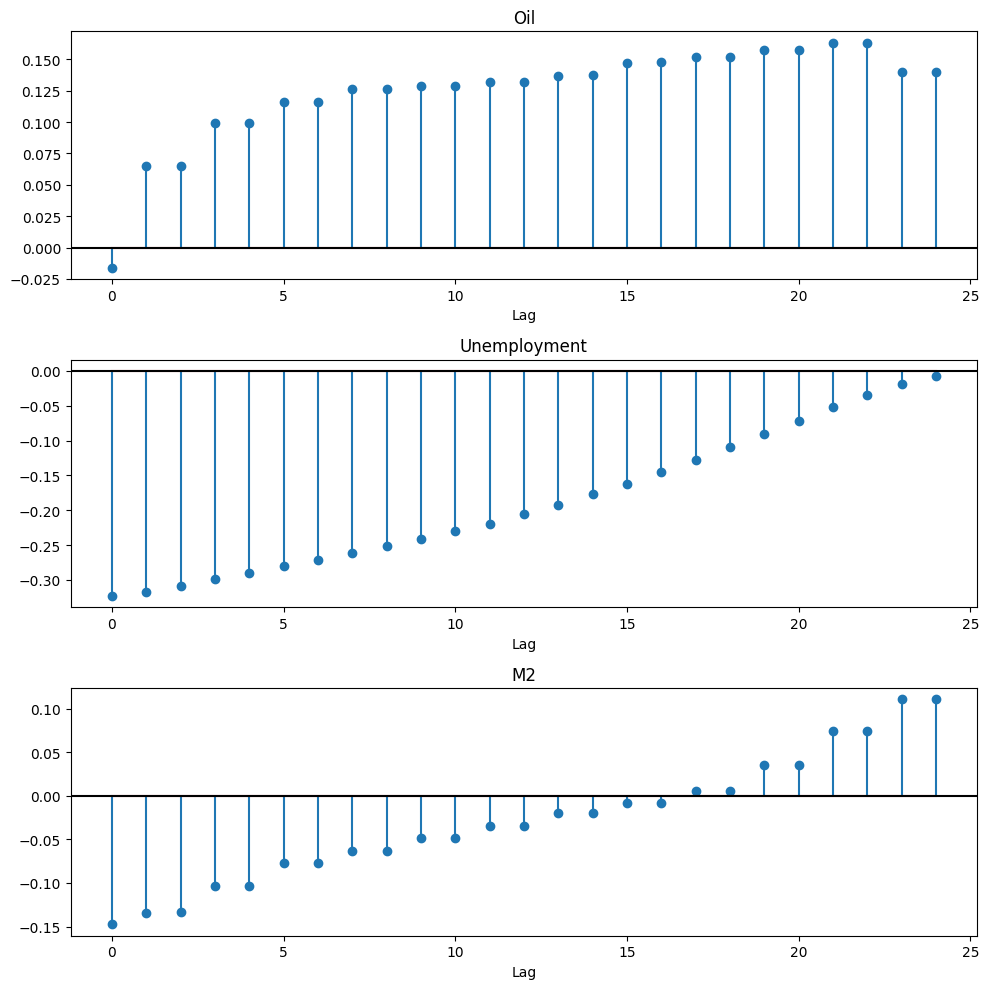

In [12]:
lags = range(0, 25)

oil_ccf = [pearsonr(inflation_exo['inflation'].iloc[lag:], 
                     inflation_exo['oil_diff'].iloc[:-lag] if lag > 0 else inflation_exo['oil_diff'])[0] 
           for lag in lags]

unemployment_ccf = [pearsonr(inflation_exo['inflation'].iloc[lag:], 
                              inflation_exo['unemployment'].iloc[:-lag] if lag > 0 else inflation_exo['unemployment'])[0] 
                    for lag in lags]

m2_ccf = [pearsonr(inflation_exo['inflation'].iloc[lag:], 
                   inflation_exo['m2_diff'].iloc[:-lag] if lag > 0 else inflation_exo['m2_diff'])[0] 
          for lag in lags]


fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].stem(lags, oil_ccf)
axes[0].set_title('Oil')
axes[0].set_xlabel('Lag')
axes[0].axhline(0, color='black')

axes[1].stem(lags, unemployment_ccf)
axes[1].set_title('Unemployment')
axes[1].set_xlabel('Lag')
axes[1].axhline(0, color='black')

axes[2].stem(lags, m2_ccf)
axes[2].set_title('M2')
axes[2].set_xlabel('Lag')
axes[2].axhline(0, color='black')

plt.tight_layout()
plt.show()